In [2]:
import os
os.environ['PATH'] += ":/content/mumax3.10"

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import Rbf

In [4]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

In [5]:
def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

In [6]:
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    return table, fields

In [12]:
# NUMERICAL PARAMETERS
fmax = 0.1e9       # maximum frequency (in Hz) of the sinc pulse
T    = 400e-9      # simulation time (longer -> better frequency resolution)
dt   = 250e-12     # the sample time

script=f"""
// Racetrack crystal settings:
length := 200e-9
width := 25e-9
delta := 100e-9
lattice_constant := 200e-9
N_unitcells := 8
Nx := 100
Ny := 256
Nz := 1
Lx := length
Ly := N_unitcells * lattice_constant
dX := length / Nx
dY := Ly / Ny
dZ := 3e-9 / Nz

setGridSize(Nx, Ny, Nz)
setCellSize(dX, dY, dZ)

// Material Constants
Bz := 0.01
Msat = 1273e3
Aex = 10e-12
anisU = vector(0, 0, 1)
Ku1 = 1.5e6
alpha = 0
Xi = 0.2
demagAccuracy = 8
pinning := false

two_racetrack := rect(length, delta+width)
racetrack := rect(length, width)

gap := delta - width

singleR := racetrack.repeat(0, lattice_constant, 0).transl(0, width/2, 0)
twoR := singleR.add(singleR.transl(0, delta, 0))

setgeom(twoR)

// Define regions
defRegion(1, singleR)
defRegion(2, singleR.transl(0, delta, 0))
defRegion(3, racetrack.transl(0, -Ly/2+width/2, 0))
save(regions)

B_ext.setregion(3, vector(0, 0, Bz*sinc(2*pi*{fmax}*(t-{T}/2))))

m.setRegion(1, twoDomain(0, 0, 1, 1, 1, 0, 0, 0, -1))
m.setRegion(2, twoDomain(0, 0, -1, 1, 1, 0, 0, 0, 1))
m.setRegion(3, twoDomain(0, 0, 1, 1, 1, 0, 0, 0, -1))
setPBC(0, 2, 0)
relax()

// Schedule output & save results
autosave(m, {dt})
tableadd(e_total)
tableautosave({dt})

// Run for 1ns with current through the sample
temp.set(1)
j = vector(0, 0, 0)
pol = 1
run({T})
"""

In [13]:
#table, fields = run_mumax3( script, name="DW_Lattice", verbose=False )

In [38]:
'''
Extract table and fields, after simulation has run
'''
name = "narrow_DW"

scriptfile = name + ".txt" 
outputdir  = name + ".out"

table = read_mumax3_table(outputdir + "/table.txt") 
fields = read_mumax3_ovffiles(outputdir)

                 t            mx        my            mz       E_total
0     0.000000e+00  3.076899e-06  0.050317 -3.142790e-09 -1.248281e-16
1     2.501622e-10  1.678455e-06  0.050317 -2.153787e-06 -1.248277e-16
2     5.000230e-10 -4.015041e-07  0.050317 -2.583103e-06 -1.248272e-16
3     7.500450e-10 -1.694205e-07  0.050317 -2.097542e-06 -1.248267e-16
4     1.000150e-09  1.930006e-06  0.050317 -2.793182e-06 -1.248264e-16
...            ...           ...       ...           ...           ...
1595  3.987501e-07 -6.958925e-03  0.041836  6.652111e-03 -1.247727e-16
1596  3.990000e-07  1.617558e-03  0.041093  8.595291e-03 -1.247726e-16
1597  3.992500e-07  6.042284e-03  0.041940  9.835290e-04 -1.247725e-16
1598  3.995001e-07  2.795710e-03  0.042634 -6.384372e-03 -1.247726e-16
1599  3.997500e-07 -3.604140e-03  0.041390 -6.135834e-03 -1.247726e-16

[1600 rows x 5 columns]


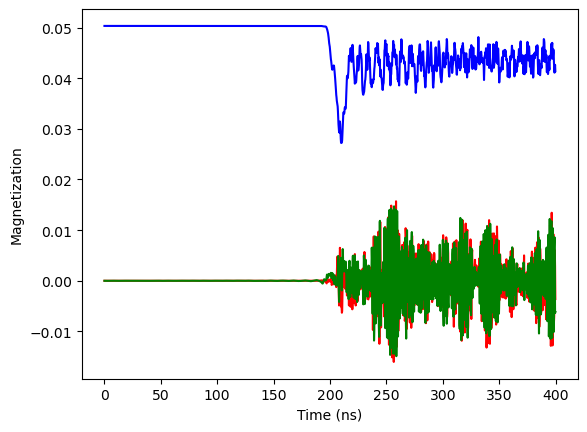

In [39]:
print(table)

plt.figure()

nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"], color='red')
plt.plot( table["t"]/nanosecond, table["my"], color='blue')
plt.plot( table["t"]/nanosecond, table["mz"], color='green')

plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")

plt.show()

In [11]:
'''
Return the value of DW position in a cell.
(By finding a point where mz == 0)
'''
def bisect(f, x_lo, x_hi, n):
    # midpoint
    x_o = (x_lo + x_hi) / 2.0
    # base case, run enough to converge.
    if n == 0:
        return x_o
    # base case, at x_o is 0
    if f(x_o) == 0:
        return x_o
    
    # ascending (-1 --> 1)
    if f(x_lo) < f(x_hi):
        if f(x_o) > 0:
            x_o = bisect(f, x_lo, x_o, n-1)
        else:
            x_o = bisect(f, x_o, x_hi, n-1)
    # descending (1 --> -1)
    else:
        if f(x_o) < 0:
            x_o = bisect(f, x_lo, x_o, n-1)
        else:
            x_o = bisect(f, x_o, x_hi, n-1)
    return x_o


In [12]:
def findDW(m):
    # *Global* values/ variables
    x_total = m.shape[3]
    y_total = m.shape[2]
    x_mid = int(m.shape[3]/2)

    DW_array = []
    DW_pos = []

    nDW = 0.0
    flag = False

    for iy in range(y_total):
        mx = m[0,0,iy,x_mid]
        my = m[1,0,iy,x_mid]
        mz = m[2,0,iy,x_mid]
        empty = (mx==0) and (my==0) and (mz==0)

        if empty:
            # Just got off the racetrack.
            if flag == True:
                DW_array.append(sum(DW_pos) / nDW)
                DW_pos = []
                nDW = 0
                flag = False
        else:
            # Just entered the racetrack.
            if flag == False:
                flag = True
            f = Rbf(np.arange(x_total), m[2,0,iy,:]) 
            DW_pos.append(bisect(f, 0, x_total, 15))
            nDW += 1
    
    return DW_array

In [13]:
def findDW_A(m):
    # *Global* values/ variables
    x_total = m.shape[3]
    y_total = m.shape[2]
    x_mid = int(m.shape[3]/2)

    DW_array = []
    DW_pos = []

    nDW = 0.0
    flag = False
    count = -1

    for iy in range(y_total):
        mx = m[0,0,iy,x_mid]
        my = m[1,0,iy,x_mid]
        mz = m[2,0,iy,x_mid]
        empty = (mx==0) and (my==0) and (mz==0)

        if empty:
            # Just got off the racetrack.
            if flag == True:
                if count%2 == 0:
                    DW_array.append(sum(DW_pos) / nDW)
                DW_pos = []
                nDW = 0
                flag = False
        else:
            # Just entered the racetrack.
            if flag == False:
                flag = True
                count += 1
            f = Rbf(np.arange(x_total), m[2,0,iy,:]) 
            DW_pos.append(bisect(f, 0, x_total, 15))
            nDW += 1
    
    return DW_array

In [14]:
def findDW_B(m):
    # *Global* values/ variables
    x_total = m.shape[3]
    y_total = m.shape[2]
    x_mid = int(m.shape[3]/2)

    DW_array = []
    DW_pos = []

    nDW = 0.0
    flag = False
    count = -1

    for iy in range(y_total):
        mx = m[0,0,iy,x_mid]
        my = m[1,0,iy,x_mid]
        mz = m[2,0,iy,x_mid]
        empty = (mx==0) and (my==0) and (mz==0)

        if empty:
            # Just got off the racetrack.
            if flag == True:
                if count%2 != 0:
                    DW_array.append(sum(DW_pos) / nDW)
                DW_pos = []
                nDW = 0
                flag = False
        else:
            # Just entered the racetrack.
            if flag == False:
                flag = True
                count += 1
            f = Rbf(np.arange(x_total), m[2,0,iy,:]) 
            DW_pos.append(bisect(f, 0, x_total, 15))
            nDW += 1
    
    return DW_array

In [16]:
pos = []
posA = []
posB = []

for key in sorted(fields.keys())[1175:]:
    if (key != "regions000000") and (key != "regions000001"):
        pos.append(findDW(fields[key]))
        posA.append(findDW_A(fields[key]))
        print("Processing: " + str(key))
        posB.append(findDW_B(fields[key]))


Processing: m000000
Processing: m000001
Processing: m000002
Processing: m000003
Processing: m000004
Processing: m000005
Processing: m000006
Processing: m000007
Processing: m000008
Processing: m000009
Processing: m000010
Processing: m000011
Processing: m000012
Processing: m000013
Processing: m000014
Processing: m000015
Processing: m000016
Processing: m000017
Processing: m000018
Processing: m000019
Processing: m000020
Processing: m000021
Processing: m000022
Processing: m000023
Processing: m000024
Processing: m000025
Processing: m000026
Processing: m000027
Processing: m000028
Processing: m000029
Processing: m000030
Processing: m000031
Processing: m000032
Processing: m000033
Processing: m000034
Processing: m000035
Processing: m000036
Processing: m000037
Processing: m000038
Processing: m000039
Processing: m000040
Processing: m000041
Processing: m000042
Processing: m000043
Processing: m000044
Processing: m000045
Processing: m000046
Processing: m000047
Processing: m000048
Processing: m000049


IndexError: index 1 is out of bounds for axis 0 with size 1

In [41]:
for key in sorted(fields.keys())[1176:]:
    if (key != "regions000000") and (key != "regions000001"):
        pos.append(findDW(fields[key]))
        posA.append(findDW_A(fields[key]))
        print("Processing: " + str(key))
        posB.append(findDW_B(fields[key]))

Processing: m001176
Processing: m001177
Processing: m001178
Processing: m001179
Processing: m001180
Processing: m001181
Processing: m001182
Processing: m001183
Processing: m001184
Processing: m001185
Processing: m001186


In [17]:
"""
Saving copy
"""
f = open('data/pos.txt',mode='w')
f.write(str(pos))

f = open('data/posA.txt',mode='w')
f.write(str(posA))

f = open('data/posB.txt',mode='w')
f.write(str(posB))

180093

In [41]:
'''
# Pos data extraction
# '''
# f = open('data/pos.txt', mode='r')
# pos = np.array(f.read())

# f = open('data/posA.txt', mode='r')
# posA = np.array(f.read())

# f = open('data/posB.txt', mode='r')
# posB = np.array(f.read())

In [18]:
# Apply the two dimensional FFT
posA_fft = np.fft.fft2(posA)
posB_fft = np.fft.fft2(posB)
posA_fft = np.fft.fftshift(posA_fft)
posB_fft = np.fft.fftshift(posB_fft)

A = np.add(np.abs(posA_fft)**2, np.abs(posB_fft)**2)
# A = np.abs(posA_fft)**2
# B = np.abs(posB_fft)**2

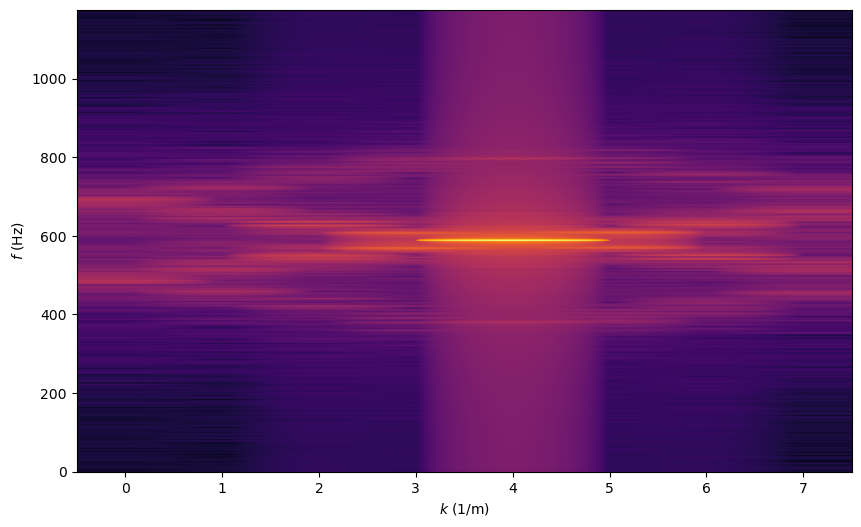

In [35]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10,6))

# Show the intensity plot of the 2D FFT
# extent = [ -(2*np.pi)/(2*dx), (2*np.pi)/(2*dx), -1/(2*dt), 1/(2*dt)] # extent of k values and frequencies

# plt.imshow(np.abs(posA_fft)**2, extent=extent, aspect='auto', origin='lower', cmap="inferno")
# plt.imshow(np.abs(posB_fft)**2, extent=extent, aspect='auto', origin='lower', cmap="inferno")
plt.imshow(A, aspect='auto', origin='lower', cmap="inferno", norm=LogNorm())
#plt.imshow(A, aspect='auto', origin='lower', cmap="inferno")

# plt.xlim([-2e8,2e8])
# plt.ylim([0,fmax])
plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")

plt.show()

In [20]:
# Plot positions along racetracks
by_track = np.transpose(pos)

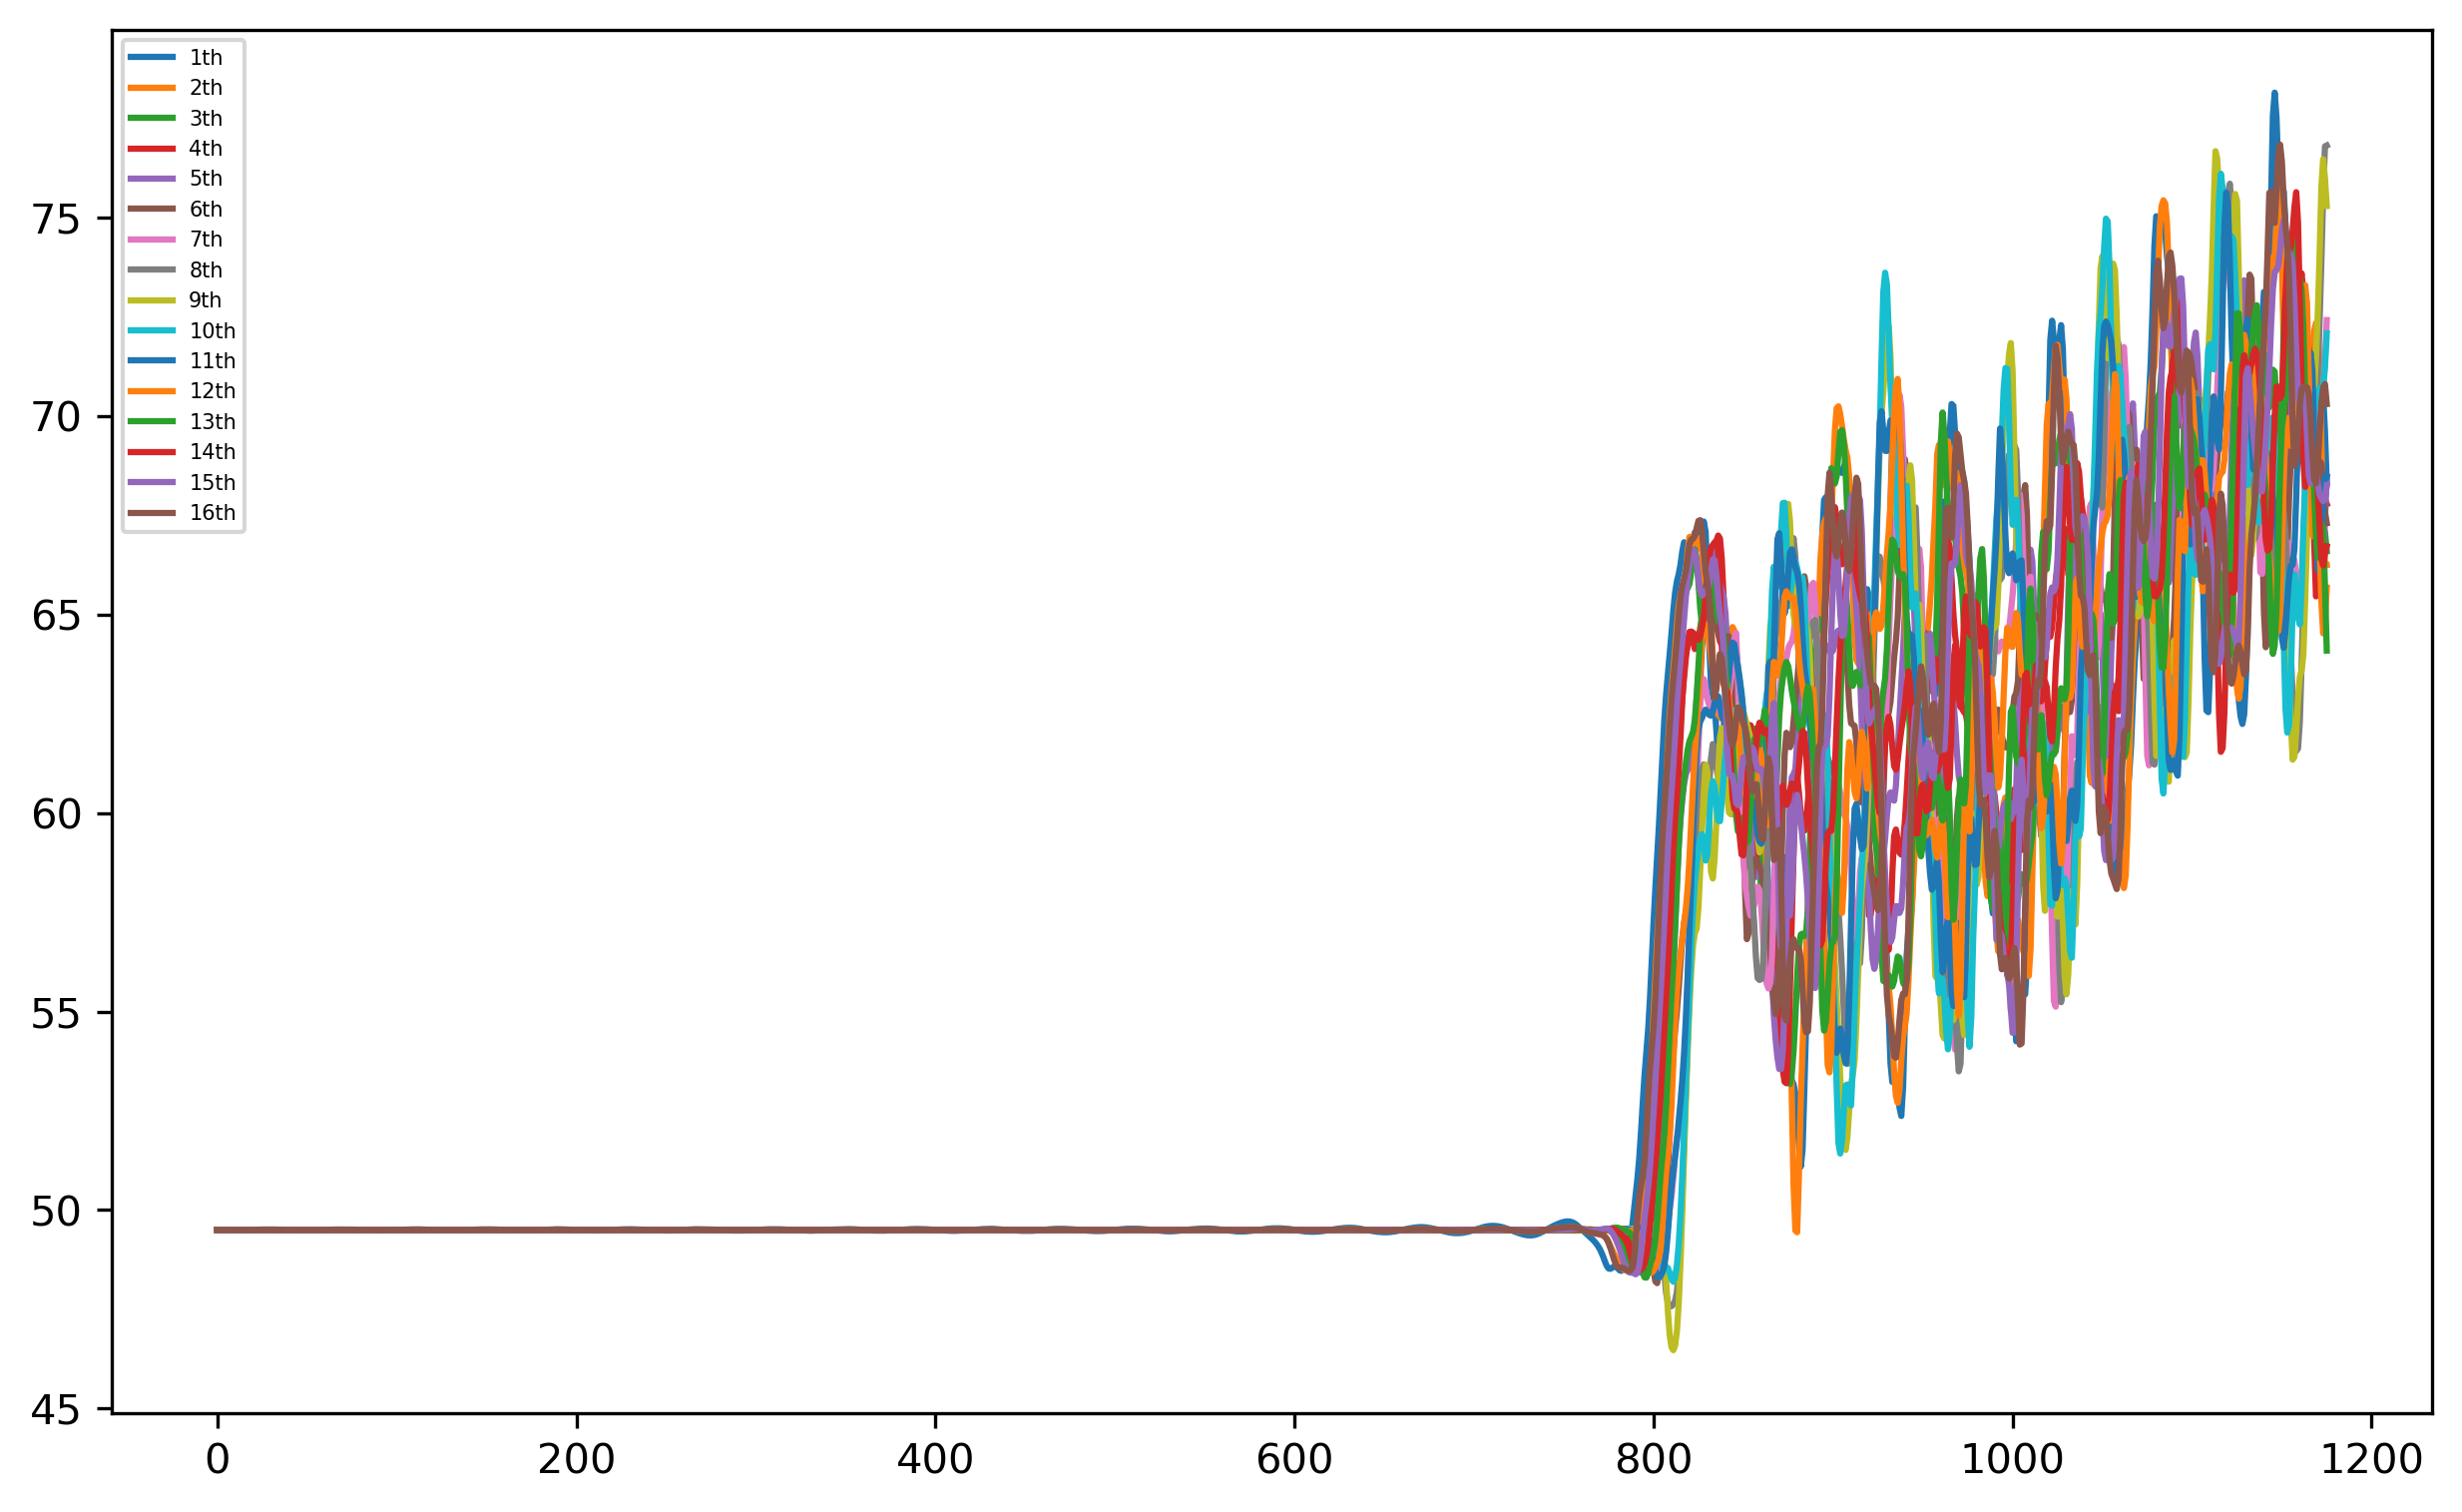

In [22]:
n_racetrack = range(by_track.shape[0])      # 16
t = range(by_track.shape[1])                # 201

plt.figure(figsize=(10, 6), dpi=300)

for nth in n_racetrack:
    plt.plot(t, by_track[nth], label=str(nth+1)+'th')

plt.legend(loc="upper left", fontsize='5')

In [23]:
n_racetrack = range(by_track.shape[0])      # 16
T_vals = np.linspace(0, T, int(T/dt)+1)

plt.figure(figsize=(10, 6), dpi=300)

for nth in n_racetrack:
    plt.plot(T_vals, by_track[nth], label=str(nth+1)+'th')

plt.legend(loc="upper left", fontsize='5')

NameError: name 'T' is not defined

In [21]:
from importlib import reload
plt=reload(plt)

n_racetrack = range(by_track.shape[0])      # 16
T_vals = np.linspace(0, T, int(T/dt)+1)

plt.figure(figsize=(5, 3), dpi=300)
resize_track = by_track * 0.25e-9

for nth in n_racetrack:
    plt.plot(T_vals, resize_track[nth], label=str(nth+1)+'th')
    
plt.legend(loc="upper left", fontsize='3')
plt.xlabel("Time (s)")
plt.ylabel("DW Position (m)")

NameError: name 'T' is not defined